In [1]:
import os
import errno

import numpy as np

import deepcell
from sklearn.model_selection import train_test_split

In [2]:
filename = 'HeLa_S3.npz'
test_size = 0.1 # % of data saved as test
seed = 0 # seed for random train-test split

a = np.load('HeLa_S3.npz')
print(a.files)


X_train = a['X'][np.arange(0,100)]
X_test = a['X'][np.arange(100,120)]
Y_train = a['y'][np.arange(0,100)]
Y_test = a['y'][np.arange(100,120)]


X_train.shape

#X_train, X_test, Y_train, Y_test = train_test_split(a['X'], a['y'], test_size = 0.1, random_state=42)


#(X_train, y_train), (X_test, y_test) = deepcell.datasets.hela_s3.load_data(
#    filename, test_size=test_size, seed=seed)

['y', 'X']


(100, 216, 256, 1)

In [3]:
from deepcell.utils.data_utils import reshape_matrix

size = 128

X_train, Y_train = reshape_matrix(X_train, Y_train, reshape_size=size)
X_test, Y_test = reshape_matrix(X_test, Y_test, reshape_size=size)
print('X.shape: {}\ny.shape: {}'.format(X_train.shape, Y_train.shape))

Reshaped feature data from (100, 216, 256, 1) to (400, 128, 128, 1)
Reshaped training data from (100, 216, 256, 1) to (400, 128, 128, 1)
Reshaped feature data from (20, 216, 256, 1) to (80, 128, 128, 1)
Reshaped training data from (20, 216, 256, 1) to (80, 128, 128, 1)
X.shape: (400, 128, 128, 1)
y.shape: (400, 128, 128, 1)


In [4]:
# change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))

# DATA_FILE should be a npz file, preferably from `make_training_data`
DATA_FILE = os.path.join(DATA_DIR, filename)


# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

In [5]:
from deepcell.model_zoo.panopticnet import PanopticNet

model = PanopticNet(
    backbone='resnet50',
    input_shape=X_train.shape[1:],
    norm_method='std',
    num_semantic_heads=3,
    num_semantic_classes=[1, 1, 2], # inner distance, outer distance, fgbg
    location=True,  # should always be true
    include_top=True)

W0820 06:17:32.822223 139979437311808 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


94773248/94765736 [==============================] - 6s 0us/step


In [6]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = 'watershed_centroid_nuclear_general_std'

n_epoch = 5  # Number of training epochs
test_size = .20  # % of data saved as test
norm_method = 'whole_image'  # data normalization

optimizer = Adam(lr=1e-5, clipnorm=0.001)
lr_sched = rate_scheduler(lr=1e-5, decay=0.99)

batch_size = 1

min_objects = 3  # throw out images with fewer than this many objects

In [7]:
from deepcell import image_generators
from deepcell.utils import train_utils

transforms = ['inner-distance', 'outer-distance', 'fgbg']
transforms_kwargs = {'outer-distance': {'erosion_width': 0}}


# use augmentation for training but not validation
datagen = image_generators.SemanticDataGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=(0.75, 1.25),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.SemanticDataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0)

train_data = datagen.flow(
    {'X': X_train, 'y': Y_train},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_test, 'y': Y_test},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

W0820 06:18:15.733360 139979437311808 semantic.py:154] Removing 338 of 400 images with fewer than 3 objects.
W0820 06:18:16.016924 139979437311808 semantic.py:154] Removing 60 of 80 images with fewer than 3 objects.


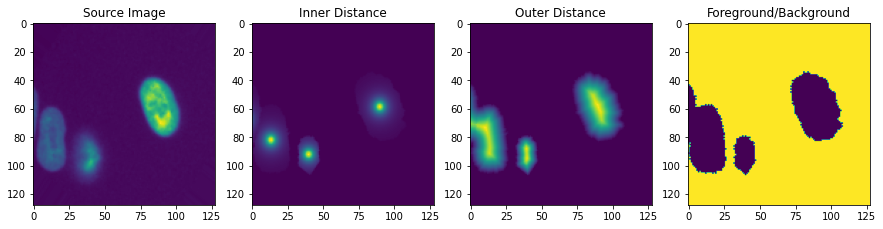

In [8]:
from matplotlib import pyplot as plt

inputs, outputs = train_data.next()

img = inputs[0]
inner_distance = outputs[0]
outer_distance = outputs[1]
fgbg = outputs[2]

fig, axes = plt.subplots(1, 4, figsize=(15, 15))

axes[0].imshow(img[..., 0])
axes[0].set_title('Source Image')

axes[1].imshow(inner_distance[0, ..., 0])
axes[1].set_title('Inner Distance')

axes[2].imshow(outer_distance[0, ..., 0])
axes[2].set_title('Outer Distance')

axes[3].imshow(fgbg[0, ..., 0])
axes[3].set_title('Foreground/Background')

plt.show()



## Loss Function for each marker

In [9]:
# Create a dictionary of losses for each semantic head
from tensorflow.python.keras.losses import MSE
from deepcell import losses


def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * losses.weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss


loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)

In [10]:
model.compile(loss=loss, optimizer=optimizer)

## Trained Model /Skip if already ran

In [ ]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus


model_path = os.path.join(MODEL_DIR, '{}.h5'.format(model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(model_name))

num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    tensorboard_log_dir=LOG_DIR,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = model.fit_generator(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

## Predict on test data

In [11]:
prediction_model = PanopticNet(
    backbone='resnet50',
    input_shape=X_train.shape[1:],
    norm_method='std',
    num_semantic_heads=2,
    num_semantic_classes=[1, 1], # inner distance, outer distance
    location=True,  # should always be true
    include_top=True)

In [12]:
model_path = os.path.join(MODEL_DIR, '{}.h5'.format(model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(model_name))


prediction_model.load_weights(model_path, by_name=True)

In [13]:
from timeit import default_timer

start = default_timer()
test_images = prediction_model.predict(X_test)
watershed_time = default_timer() - start

print('Watershed segmentation of shape', test_images[0].shape, 'in', watershed_time, 'seconds.')

Watershed segmentation of shape (80, 128, 128, 1) in 6.72465440000002 seconds.


65
[127 126 122]
[106 106   0]


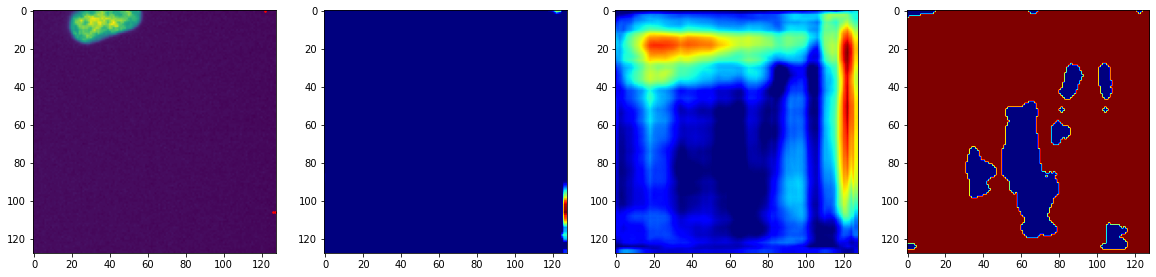

(80, 128, 128, 1)


In [26]:
import time

from matplotlib import pyplot as plt
import numpy as np

from skimage.feature import peak_local_max

from deepcell_toolbox.deep_watershed import deep_watershed

index = np.random.choice(X_test.shape[0])
print(index)


fig, axes = plt.subplots(1, 4, figsize=(20, 20))

masks = deep_watershed(
    test_images,
    min_distance=10,
    detection_threshold=0.1,
    distance_threshold=0.01,
    exclude_border=False,
    small_objects_threshold=0)

# calculated in the postprocessing above, but useful for visualizing
inner_distance = test_images[0]
outer_distance = test_images[1]

coords = peak_local_max(
    inner_distance[index],
    min_distance=10,
    threshold_abs=0.1,
    exclude_border=False)

# raw image with centroid
axes[0].imshow(X_test[index, ..., 0])
axes[0].scatter(coords[..., 1], coords[..., 0],
                color='r', marker='.', s=10)

print(coords[...,1])
print(coords[...,0])

axes[1].imshow(inner_distance[index, ..., 0], cmap='jet')
axes[2].imshow(outer_distance[index, ..., 0], cmap='jet')
axes[3].imshow(masks[index, ...], cmap='jet')

plt.show()

len(coords[..., 1])

print(X_test.shape)

## Evaluate results

In [15]:
from deepcell_toolbox.metrics import Metrics
from skimage.morphology import watershed, remove_small_objects
from skimage.segmentation import clear_border

outputs = model.predict(X_test)

y_pred = []

for i in range(outputs[0].shape[0]):

    mask = deep_watershed(
        [t[[i]] for t in outputs],
        min_distance=10,
        detection_threshold=0.1,
        distance_threshold=0.01,
        exclude_border=False,
        small_objects_threshold=0)

    y_pred.append(mask[0])

y_pred = np.stack(y_pred, axis=0)
y_pred = np.expand_dims(y_pred, axis=-1)
y_true = Y_test.copy()

print('DeepWatershed - Remove no pixels')
m = Metrics('DeepWatershed - Remove no pixels', seg=False)
m.calc_object_stats(y_true, y_pred)
print('\n')

for i in range(y_pred.shape[0]):
    y_pred[i] = remove_small_objects(y_pred[i].astype(int), min_size=100)
    y_true[i] = remove_small_objects(y_true[i].astype(int), min_size=100)

print('DeepWatershed - Remove objects < 100 pixels')
m = Metrics('DeepWatershed - Remove 100 pixels', seg=False)
m.calc_object_stats(y_true, y_pred)
print('\n')

DeepWatershed - Remove no pixels


/usr/local/lib/python3.6/dist-packages/deepcell_toolbox/metrics.py:114: RuntimeWarning: invalid value encountered in long_scalars
  precision = intersection.sum() / pred.sum()
/usr/local/lib/python3.6/dist-packages/deepcell_toolbox/metrics.py:104: UserWarning: DICE score is technically 1.0, but prediction and truth arrays are empty. 
  warnings.warn('DICE score is technically 1.0, '
/usr/local/lib/python3.6/dist-packages/deepcell_toolbox/metrics.py:112: RuntimeWarning: invalid value encountered in long_scalars
  dice = (2 * intersection.sum() / (pred.sum() + truth.sum()))
/usr/local/lib/python3.6/dist-packages/deepcell_toolbox/metrics.py:113: RuntimeWarning: invalid value encountered in long_scalars
  jaccard = intersection.sum() / union.sum()
/usr/local/lib/python3.6/dist-packages/deepcell_toolbox/metrics.py:115: RuntimeWarning: invalid value encountered in long_scalars
  recall = intersection.sum() / truth.sum()



____________Object-based statistics____________

Number of true cells:		 134
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 134	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 



DeepWatershed - Remove objects < 100 pixels


/usr/local/lib/python3.6/dist-packages/deepcell_toolbox/metrics.py:867: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['correct_detections'].sum() / self.stats['n_pred'].sum(),
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?



____________Object-based statistics____________

Number of true cells:		 116
Number of predicted cells:	 0

Correct detections:  0	Recall: 0%
Incorrect detections: 0	Precision: NaN%

Gained detections: 0	Perc Error: 0%
Missed detections: 116	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0 





### Centroids at each of the test data: Write to file

In [17]:
#Centroids at each of the test data

coords = peak_local_max(
    inner_distance[index],
    min_distance=10,
    threshold_abs=0.1,
    exclude_border=False)

#where index is any of the test images






In [25]:
#Average Intensities
#markername
def num_coords(coords): #counts number of coords in current FOV
    
    len(coords)
    
#export the x and y coordinate into a text file by iterating through
#FOV number/index

def export_centroids(num_images):

    file_object  = open("Test Data Centroids.txt", "w")
    index = 0
    
    file_object.write("Format\n")
    file_object.write("FOV\n")
    file_object.write("[X1 X2 ....]\n")
    file_object.write("[Y1 Y2 ....]\n")
    file_object.write("\n")
    
    
    for i in range(0, num_images):
    
        coords = peak_local_max(
        inner_distance[index],
        min_distance=10,
        threshold_abs=0.1,
        exclude_border=False)
        
        num = num_coords(coords[...,1])
        
      
        file_object.write(str(index+1)+"\n")
        file_object.write(str(coords[...,1])+"\n")
        file_object.write(str(coords[...,0])+"\n")
        file_object.write("\n")
        
        index+=1
        

    
    file_object.close() 
    

        
export_centroids(80)

## Extracting Intensity Information



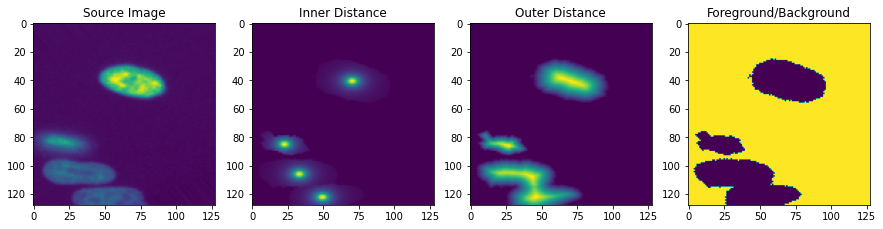

In [29]:
# Exmaple Image
inputs, outputs = train_data.next()

img = inputs[0]
inner_distance = outputs[0]
outer_distance = outputs[1]
fgbg = outputs[2]

fig, axes = plt.subplots(1, 4, figsize=(15, 15))

axes[0].imshow(img[..., 0])
axes[0].set_title('Source Image')


axes[1].imshow(inner_distance[0, ..., 0])
axes[1].set_title('Inner Distance')

axes[2].imshow(outer_distance[0, ..., 0])
axes[2].set_title('Outer Distance')

axes[3].imshow(fgbg[0, ..., 0])
axes[3].set_title('Foreground/Background')

plt.show()